# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [122]:
!pip install plotly --upgrade --quiet

In [123]:
import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

import scipy.stats as stats

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


import matplotlib

%matplotlib inline

warnings.filterwarnings("ignore")

In [124]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

from sklearn import metrics 
from sklearn.model_selection import  train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler

In [126]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [127]:
print(f"This dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

This dataset contains 50000 rows and 14 columns.


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [129]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [130]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [131]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [132]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [133]:
df.describe(include = "object")

,sales_channel,trip_type,route,booking_origin
count,50000,50000,50000,50000
unique,2,3,799,104
top,Internet,RoundTrip,AKLKUL,Australia
freq,44382,49497,2680,17872


In [134]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [135]:
df.dropna(inplace=True)

In [136]:
df.isnull().sum().sum()

0

There are no null values present in the dataset.

In [137]:
df.duplicated().sum()

719

There are total 719 duplicate values in the dataset. We need to remove these data.

In [138]:
# drop duplicate rows
df = df.drop_duplicates()
df.duplicated().sum()

0

In [139]:
numeric_columns = [feature for feature in df.columns if df[feature].dtype != 'O']

In [140]:
print(f"This dataset contains {len(numeric_columns)} numeric columns.")
print(f"These columns are  {numeric_columns}")

This dataset contains 10 numeric columns.
These columns are  ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']


In [141]:
categorical_columns = [feature for feature in df.columns if df[feature].dtype == 'O']

In [142]:
print(f"This dataset contains {len(categorical_columns)} categorical columns.")
print(f"These columns are  {categorical_columns}")

This dataset contains 4 categorical columns.
These columns are  ['sales_channel', 'trip_type', 'route', 'booking_origin']


### Exploratory Data Analysis

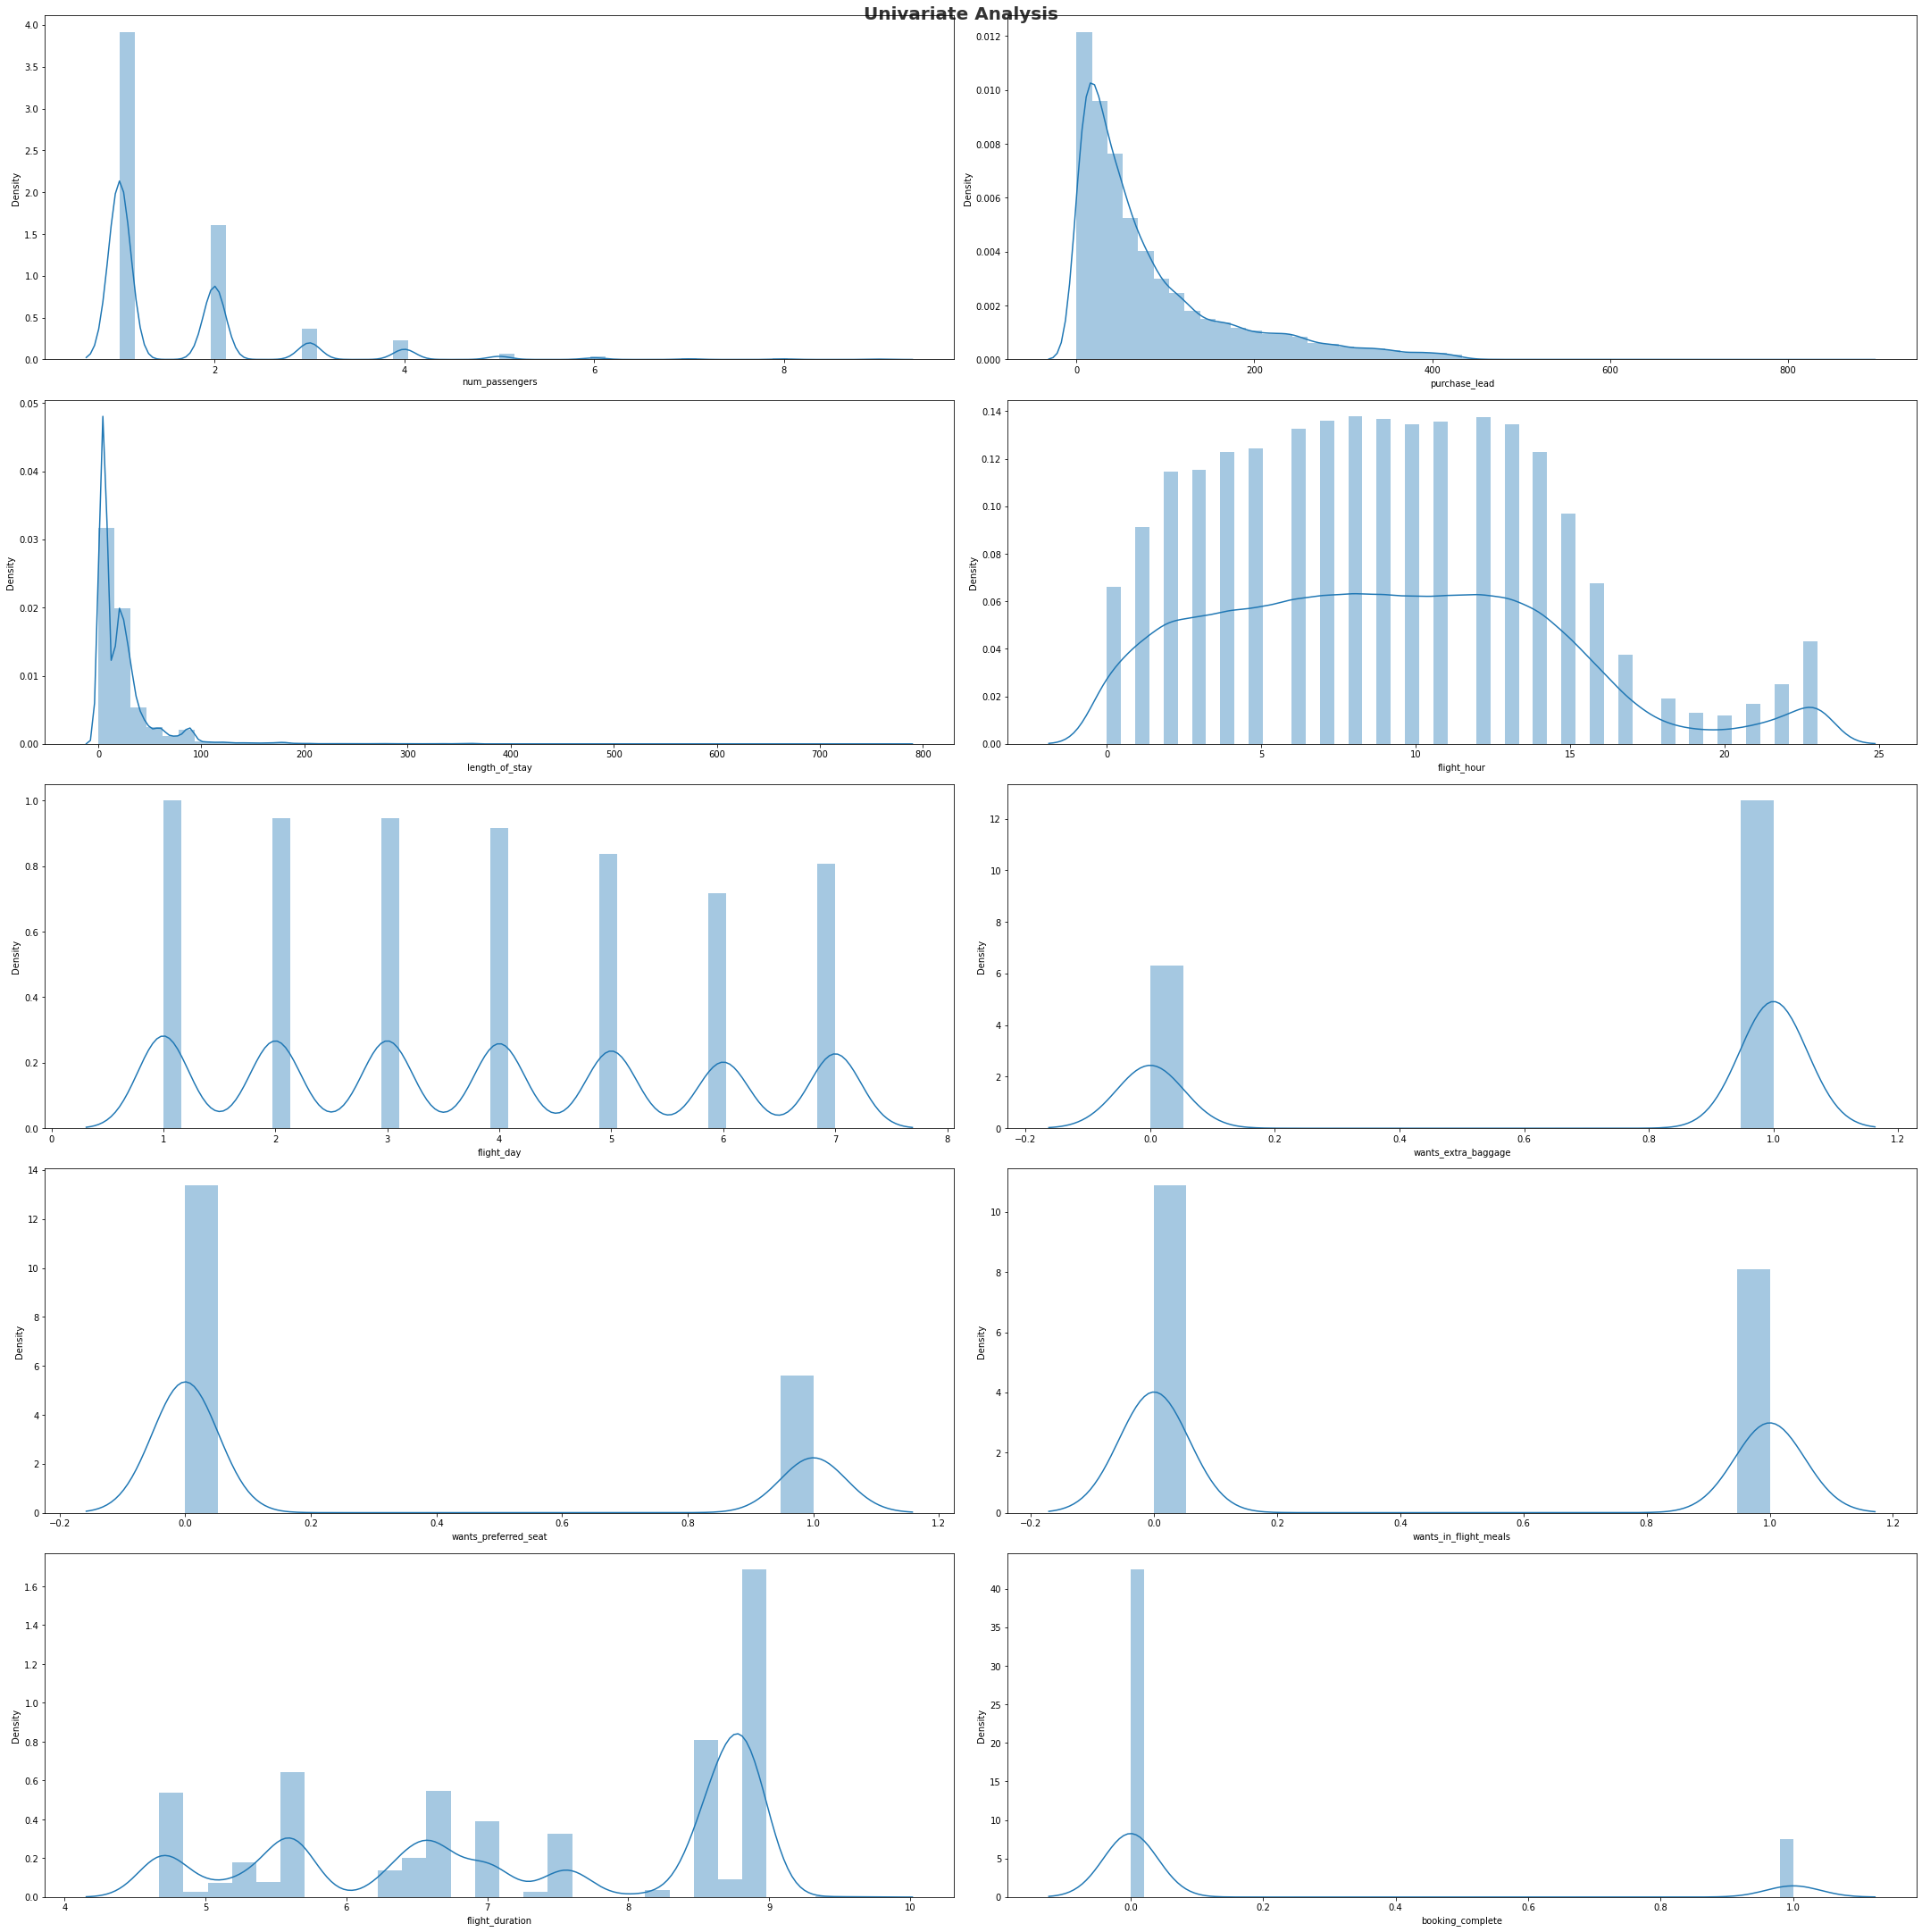

In [143]:
plt.figure(figsize=(30, 30))
plt.suptitle('Univariate Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_columns)):
    plt.subplot(5, 2, i+1)
    sns.distplot(x=df[numeric_columns[i]],kde=True)
    plt.xlabel(numeric_columns[i])
    plt.tight_layout()

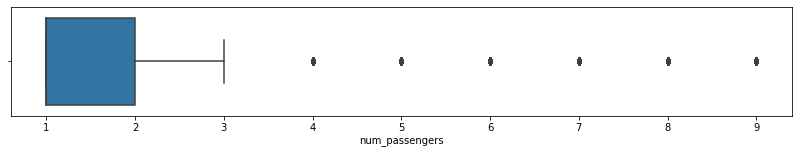

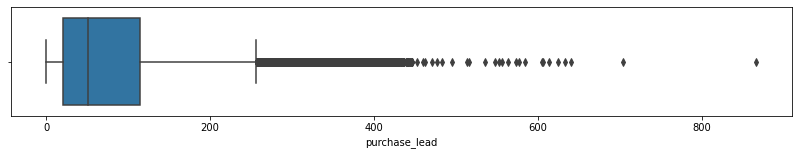

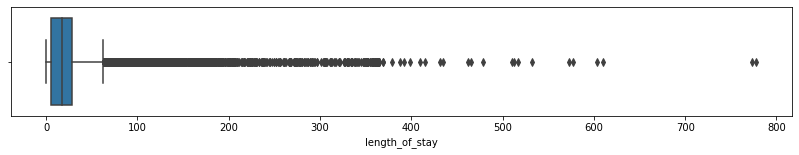

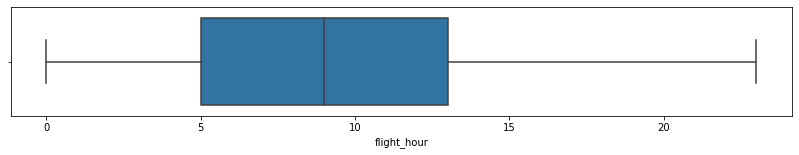

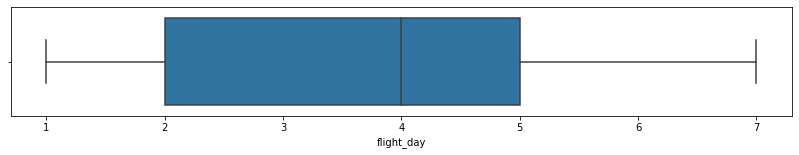

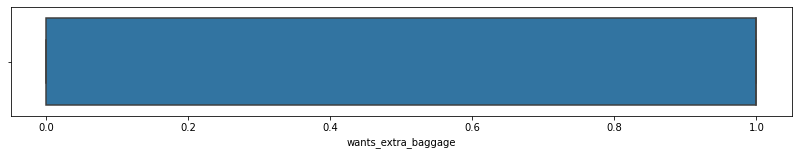

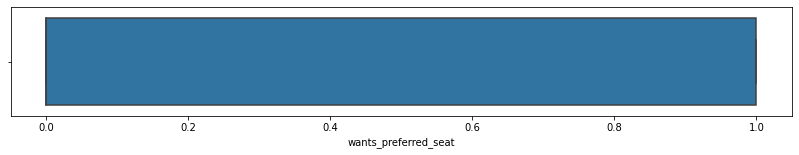

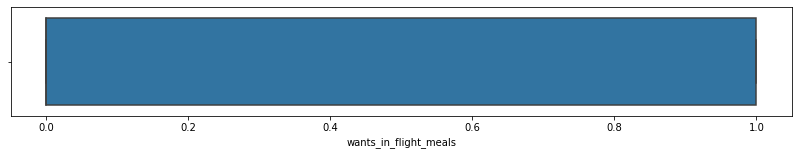

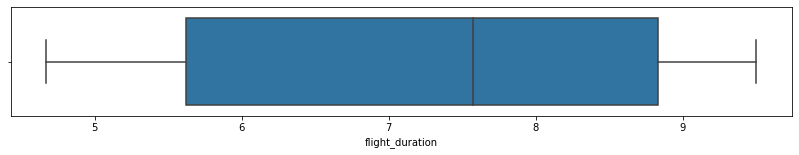

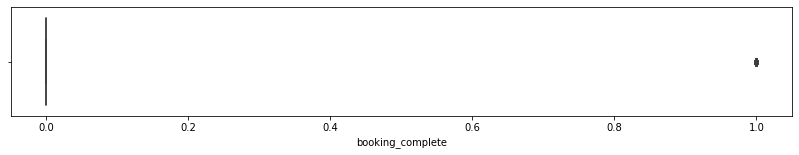

In [144]:
for column in numeric_columns:
    plt.figure(figsize=(14,2))
    sns.boxplot(x=column,data=df)
    plt.show()

In [145]:
def diagnostic_plots(df, variable):
    '''
    function to plot a histogram and a Q-Q plot
    side by side, for a certain variable
    '''
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.xlabel(variable)
    plt.title('Histogram')

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(variable)
    plt.title('Q-Q plot')
    plt.show()

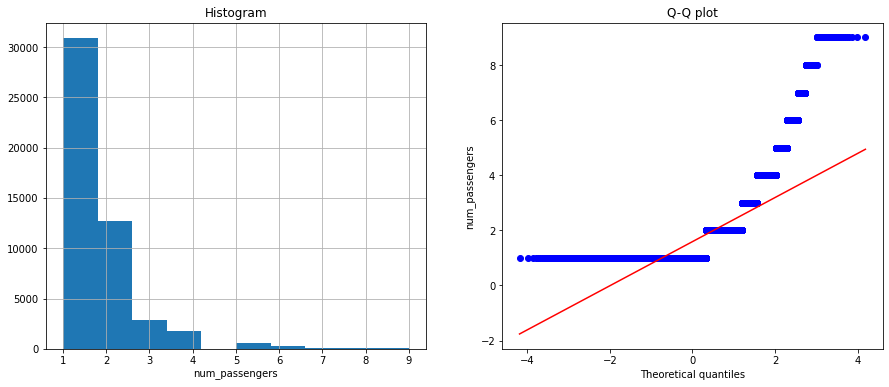

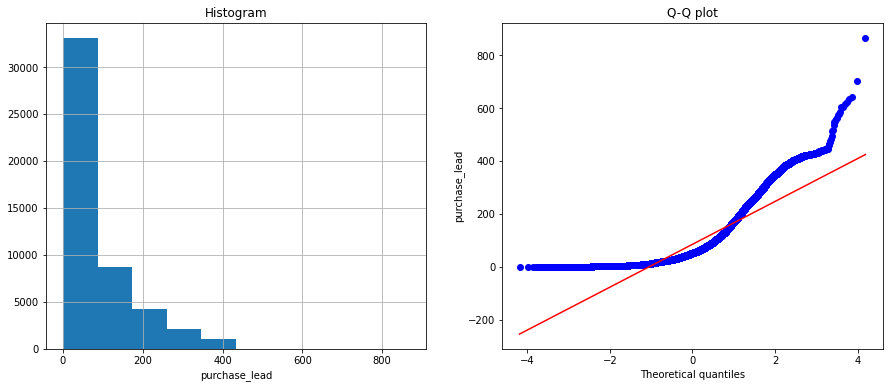

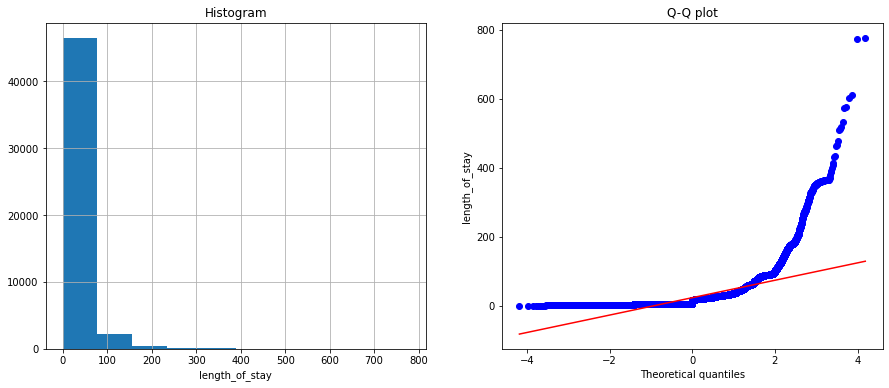

In [146]:
for col in ['num_passengers', 'purchase_lead', 'length_of_stay']:
  diagnostic_plots(df, col)

In [147]:
fig = px.histogram(df, x='num_passengers')
fig.update_layout(title='Number of Passengers Histogram', bargap =0.2)
fig.show()

In [148]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [149]:
for i in ['sales_channel', 'trip_type', 'route', 'booking_origin']:
  print("#"*50)
  print(pd.crosstab(df['booking_complete'], df[i]))

##################################################
sales_channel     Internet  Mobile
booking_complete                  
0                    37115    4775
1                     6802     589
##################################################
trip_type         CircleTrip  OneWay  RoundTrip
booking_complete                               
0                        111     366      41413
1                          5      20       7366
##################################################
route             AKLDEL  AKLHGH  AKLHND  AKLICN  AKLKIX  AKLKTM  AKLKUL  \
booking_complete                                                           
0                     20       1       2      69       8       7    2061   
1                      0       0       0       0       0       0     559   

route             AKLMRU  AKLPEK  AKLPVG  ...  TGGXIY  TPETRZ  TPETWU  TPEURT  \
booking_complete                          ...                                   
0                      6       1       2  ...   

In [150]:
from sklearn.preprocessing import LabelEncoder

In [151]:
# Create an instance of the LabelEncoder class
le = LabelEncoder()

In [152]:
# Fit and transform categorical column using the LabelEncoder
for i in categorical_columns:
  df[i] = le.fit_transform(df[i])

In [153]:
y = df['booking_complete']
x = df.drop(['booking_complete'], axis = 1)

In [154]:
x.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
dtype: int64

In [155]:
from imblearn.over_sampling import SMOTE
x_resmple, y_resmple = SMOTE().fit_resample(x, y.values.ravel())

In [156]:
print(x_resmple.shape)
print(y_resmple.shape)

(83780, 13)
(83780,)


In [157]:
# Train test Split
from sklearn.model_selection import train_test_split

In [158]:
x_train, x_test, y_train,y_test = train_test_split(x_resmple, y_resmple, test_size = 0.2, random_state = 0)

In [159]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "AdaBoost Classifier": AdaBoostClassifier()
    }

In [160]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [161]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    
        print('='*35)
        print('\n')

In [162]:
evaluate_models(x_resmple,y_resmple,models)

Random Forest
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 0.9999
- Recall: 1.0000
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.8763
- F1 score: 0.8784
- Precision: 0.8703
- Recall: 0.8868
- Roc Auc Score: 0.8763


Decision Tree
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9999
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.8273
- F1 score: 0.8325
- Precision: 0.8139
- Recall: 0.8519
- Roc Auc Score: 0.8271


Gradient Boosting
Model performance for Training set
- Accuracy: 0.7847
- F1 score: 0.7958
- Precision: 0.7556
- Recall: 0.8405
- Roc Auc Score: 0.7848
----------------------------------
Model performance for Test set
- Accuracy: 0.7838
- F1 score: 0.7948
- Precision: 0.7617
- Recall: 0.8310
- Roc Auc Score: 0.7835


Logistic Regression
Model performance for Training 

In [163]:
# Create an instance of the RandomForestClassifier
clf = RandomForestClassifier()

In [164]:
# Define the hyperparameter grid
param_grid = {'n_estimators': [50, 100, 200, 250, 300],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3]}

In [165]:
# Create an instance of the GridSearchCV class
grid_search = GridSearchCV(clf, param_grid, cv=5)

In [166]:
# Fit the GridSearchCV class to the data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200, 250, 300]})

In [167]:
# Get the best hyperparameters
best_params = grid_search.best_params_

In [168]:
# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
print("Best f1 score: ", grid_search.best_score_)

Best parameters:  {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Best f1 score:  0.8699869301430503


In [169]:
final_model = RandomForestClassifier(**grid_search.best_params_)

In [170]:
final_model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=250)

Text(0.5, 1.0, 'FEATURE IMPORTANCES')

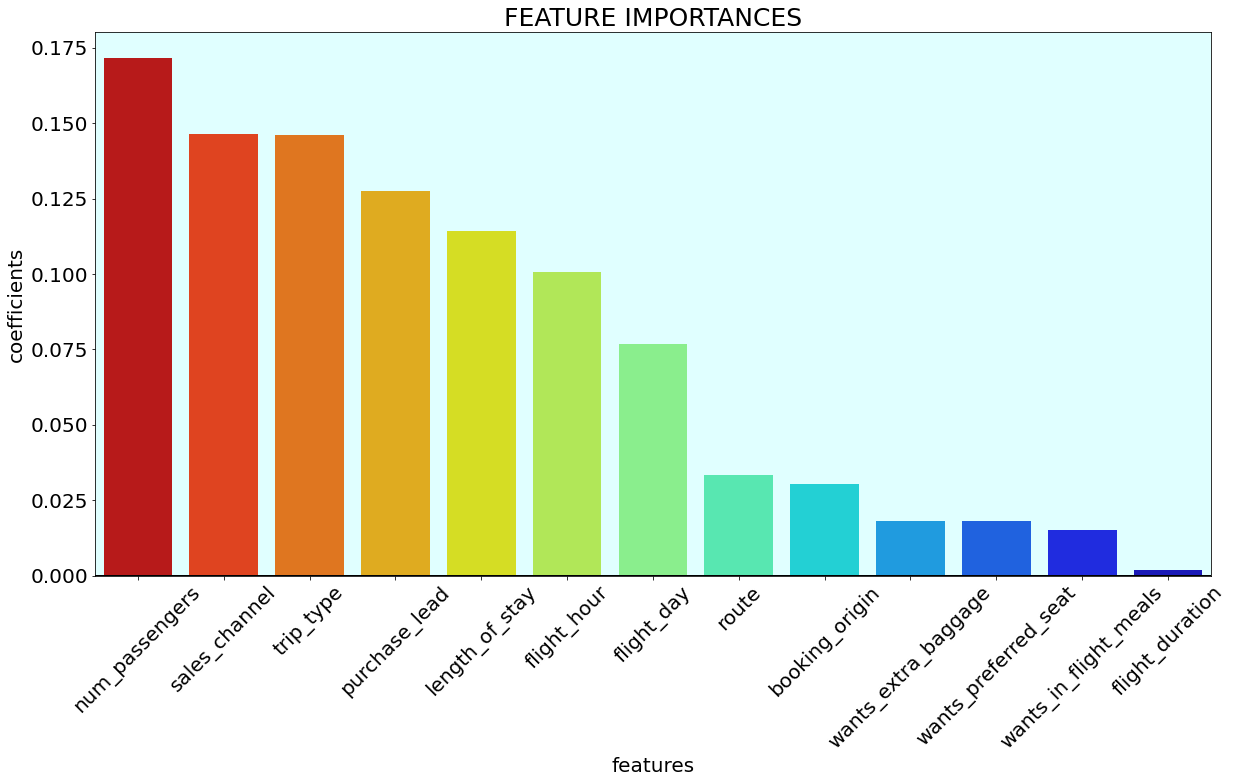

In [195]:
# FEATURE IMPORTANCES plot
plt.figure(figsize=(20,10))
#plt.subplot(211)
coef = pd.DataFrame(np.sort(final_model.feature_importances_)[::-1])
coef["feat"] = x_train.columns
ax1 = sns.barplot(coef["feat"], coef[0],palette="jet_r", linewidth=2)
ax1.set_facecolor("lightcyan")
ax1.axhline(0,color="k",linewidth=2)
plt.ylabel("coefficients", fontsize=20)
plt.xlabel("features", fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.title('FEATURE IMPORTANCES', fontsize=25)

In [187]:
# Save the plot to a PNG file
plt.savefig("feature_importance.png")

<Figure size 432x288 with 0 Axes>

In [173]:
# Get the feature importances
feature_importances = final_model.feature_importances_

# Print the feature importances
for feature, importance in zip(df.columns, feature_importances):
    print("Feature: ", feature, "\nImportance: ", importance)

Feature:  num_passengers 
Importance:  0.030382602931857638
Feature:  sales_channel 
Importance:  0.033302920443236246
Feature:  trip_type 
Importance:  0.001946666638272284
Feature:  purchase_lead 
Importance:  0.14622332890331985
Feature:  length_of_stay 
Importance:  0.11413079240204403
Feature:  flight_hour 
Importance:  0.10057658543442577
Feature:  flight_day 
Importance:  0.07689063728984656
Feature:  route 
Importance:  0.1461631962862637
Feature:  booking_origin 
Importance:  0.17159974400120726
Feature:  wants_extra_baggage 
Importance:  0.018057974198809848
Feature:  wants_preferred_seat 
Importance:  0.015016325783853628
Feature:  wants_in_flight_meals 
Importance:  0.018190728212944148
Feature:  flight_duration 
Importance:  0.12751849747391913


In [174]:
y_pred = final_model.predict(x_test.values)

In [175]:
print("Traning Accuracy", final_model.score(x_train, y_train))
print("Test Accuracy", final_model.score(x_test, y_test))

Traning Accuracy 0.9998955597994749
Test Accuracy 0.878312246359513


In [176]:
print("Our Model Accuracy is",accuracy_score(y_pred, y_test) )

Our Model Accuracy is 0.878312246359513


In [177]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      8279
           1       0.87      0.89      0.88      8477

    accuracy                           0.88     16756
   macro avg       0.88      0.88      0.88     16756
weighted avg       0.88      0.88      0.88     16756



In [178]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)